### Read First

The work in this notebook is an attempt to find a method to train a DNN LSTM in as a supervised DNN LSTM method. The dataset is obtained from data.gov.in and contains temperature and rainfall data from year 1901 to 2016. Total number of data were very less - 116. LSTM and few other statistical methods could capture the variability of temperature very well but failed in case of rainfall prediction. To compensate for less data, supervised DNN LSTM method has been been thought of. 
``` With LSTMs capturing temperature variabilty very well, furture values of temperature are predicted using LSTM prdiction. Let these predicted temperature values be called "Future temperatures". Then Dependency of rainfall on temperature parameters was found out with X being temperature parameters and Y being rainfall in multivariate Y = aX + b. Then with X = "Future temperatures", Y = "Future rainfall" could be very well predicted. ```


In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from numpy import array
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error
from math import sqrt

%matplotlib inline

In [2]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [3]:
data_dir = '/data'
filename = '/data.csv'

data_df = pd.read_csv('data/data.csv')

In [4]:
data_df.head()
print(data_df.shape)

(116, 44)


In [5]:
print(data_df.columns.values)

['year' 'annual-min' 'jan-min' 'feb-min' 'mar-min' 'apr-min' 'may-min'
 'jun-min' 'jul-min' 'aug-min' 'sep-min' 'oct-min' 'nov-min' 'dec-min'
 'annual-max' 'jan-max' 'feb-max' 'mar-max' 'apr-max' 'may-max' 'jun-max'
 'jul-max' 'aug-max' 'sep-max' 'oct-max' 'nov-max' 'dec-max' 'annual-mean'
 'jan-mean' 'feb-mean' 'mar-mean' 'apr-mean' 'may-mean' 'jun-mean'
 'jul-mean' 'aug-mean' 'sep-mean' 'oct-mean' 'nov-mean' 'dec-mean'
 'jun-rain' 'jul-rain' 'aug-rain' 'sept-rain']


In [6]:
data_df.head()

,year,annual-min,jan-min,feb-min,mar-min,apr-min,may-min,jun-min,jul-min,aug-min,...,jul-mean,aug-mean,sep-mean,oct-mean,nov-mean,dec-mean,jun-rain,jul-rain,aug-rain,sept-rain
0,1901,19.51,13.58,14.72,17.91,20.93,23.18,24.05,23.82,23.58,...,27.49,26.98,26.26,25.08,21.73,18.95,99.3,295.4,354.8,113.8
1,1902,19.44,13.08,14.20,18.44,21.30,23.63,23.97,23.68,23.34,...,27.29,27.05,25.95,24.37,21.33,18.78,62.3,334.2,237.6,216.0
2,1903,19.25,13.20,14.55,17.12,20.67,22.95,23.85,23.53,23.29,...,28.04,26.63,26.34,24.57,20.96,18.29,96.2,392.7,286.6,211.5
3,1904,19.22,13.04,14.07,17.70,21.42,23.02,23.64,23.35,23.03,...,26.84,26.73,25.84,24.36,21.07,18.84,180.5,259.1,200.9,165.8
4,1905,19.03,12.83,12.74,16.88,19.62,23.32,24.13,23.93,24.31,...,27.67,27.47,26.29,26.16,22.07,18.71,59.8,340.6,178.9,204.1


In [7]:
data_df.tail()

,year,annual-min,jan-min,feb-min,mar-min,apr-min,may-min,jun-min,jul-min,aug-min,...,jul-mean,aug-mean,sep-mean,oct-mean,nov-mean,dec-mean,jun-rain,jul-rain,aug-rain,sept-rain
111,2012,19.54,12.91,14.45,17.79,21.30,23.15,24.22,24.12,23.69,...,27.98,27.31,26.65,24.85,22.26,19.91,99.3,311.9,305.5,218.2
112,2013,19.83,13.22,15.54,18.45,21.29,23.68,24.08,23.94,23.70,...,27.50,27.22,26.87,25.63,22.18,19.69,275.9,437.6,299.2,180.7
113,2014,19.77,13.79,14.72,17.73,21.07,23.16,24.68,24.37,23.58,...,28.07,27.42,26.61,25.38,22.53,19.50,64.6,358.5,256.4,201.1
114,2015,19.96,13.51,15.55,17.99,21.18,23.54,23.82,24.28,23.82,...,28.03,27.64,27.04,25.82,22.95,20.21,204.5,267.9,204.8,141.8
115,2016,21.28,14.91,17.44,20.59,23.75,25.10,25.36,24.72,24.56,...,28.18,28.17,27.72,26.81,23.90,21.89,137.3,382.9,320.9,194.6


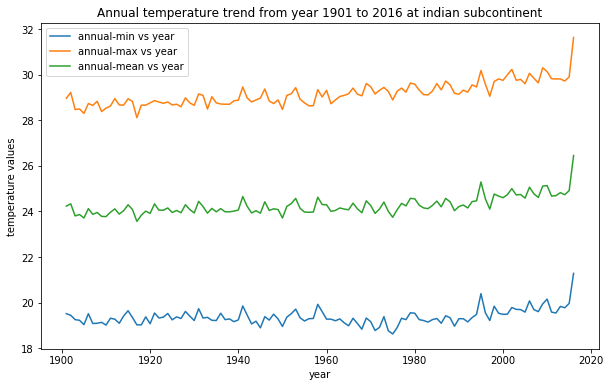

In [8]:
#visualizing the temperature data
plt.figure(figsize=(10,6))
plt.plot(data_df['year'], data_df['annual-min'], label='annual-min vs year') 
plt.plot(data_df['year'], data_df['annual-max'], label='annual-max vs year')
plt.plot(data_df['year'], data_df['annual-mean'], label='annual-mean vs year')
plt.title('Annual temperature trend from year 1901 to 2016 at indian subcontinent')
plt.legend(loc='best')
plt.xlabel('year')
plt.ylabel('temperature values')
plt.show()

It can be seen that there has been an evident rise in all format of temperatures along the year. Also, on careful visualization, one can see more sharp rise in later years than early years.

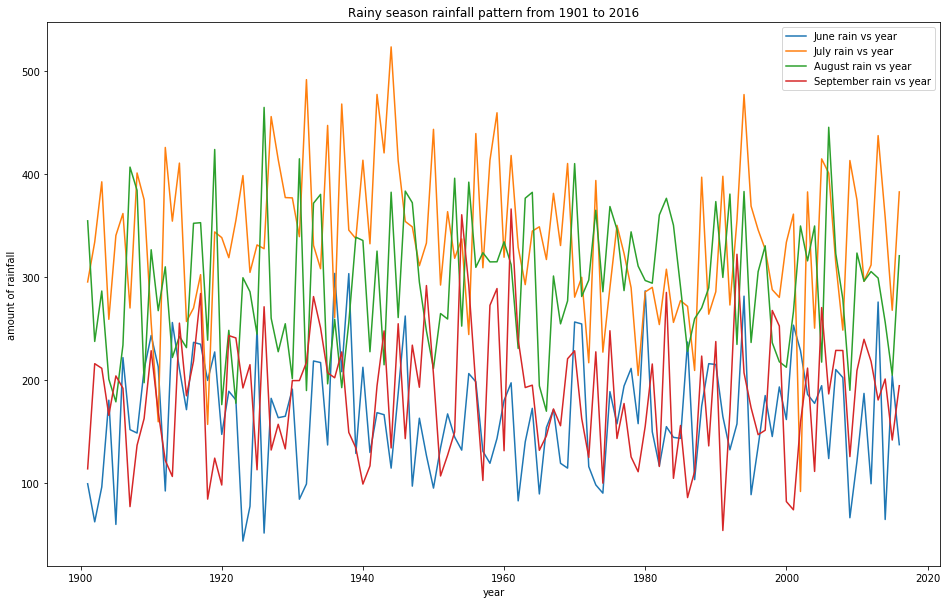

In [9]:
#Visualizing the rainfall data
plt.figure(figsize=(16,10))
plt.plot(data_df['year'], data_df['jun-rain'], label='June rain vs year')
plt.plot(data_df['year'], data_df['jul-rain'], label='July rain vs year')
plt.plot(data_df['year'], data_df['aug-rain'], label='August rain vs year')
plt.plot(data_df['year'], data_df['sept-rain'], label='September rain vs year')
plt.title('Rainy season rainfall pattern from 1901 to 2016')
plt.legend(loc='best')
plt.xlabel('year')
plt.ylabel('amount of rainfall')
plt.show()

Clearly it can be seen that month of June and September which marks beginning and end of monsoon in india get similar amount of rainfall with maximum rainfall happening in month of July followed by August.

In [10]:
train = data_df[:100]
test = data_df[100:]

In [11]:
train1 = train.copy()

In [12]:
train1 = train1.drop(['year'], axis=1)

In [13]:
headers = list(train1.columns.values)

In [14]:
print(headers)

['annual-min', 'jan-min', 'feb-min', 'mar-min', 'apr-min', 'may-min', 'jun-min', 'jul-min', 'aug-min', 'sep-min', 'oct-min', 'nov-min', 'dec-min', 'annual-max', 'jan-max', 'feb-max', 'mar-max', 'apr-max', 'may-max', 'jun-max', 'jul-max', 'aug-max', 'sep-max', 'oct-max', 'nov-max', 'dec-max', 'annual-mean', 'jan-mean', 'feb-mean', 'mar-mean', 'apr-mean', 'may-mean', 'jun-mean', 'jul-mean', 'aug-mean', 'sep-mean', 'oct-mean', 'nov-mean', 'dec-mean', 'jun-rain', 'jul-rain', 'aug-rain', 'sept-rain']


# Simple Exponential Smoothing
While working on time series problem, one needs  to attach larger weights to more recent observations than to observations from the distant past. The technique which works on this principle is called Simple exponential smoothing. Forecasts are calculated using weighted averages where the weights decrease exponentially as observations come from further in the past, the smallest weights are associated with the oldest observations:

$$ŷ_(t+1|t) =  α*y(t) + α(1-α)*y(t-1) + α(1-α)^{2} * y(t-2) + ....$$

where 0≤ α ≤1 is the smoothing parameter.
The one-step-ahead forecast for time T+1 is a weighted average of all the observations in the series y1,…,yT. The rate at which the weights decrease is controlled by the parameter α.

In [15]:
y_hat_exp = test.copy()
for header in headers:
    fit_exp = SimpleExpSmoothing(np.asarray(train1[header])).fit(smoothing_level=0.3, optimized=False)
    y_hat_exp[header] = fit_exp.forecast(len(test))



In [16]:
y_hat_exp.head()

,year,annual-min,jan-min,feb-min,mar-min,apr-min,may-min,jun-min,jul-min,aug-min,...,jul-mean,aug-mean,sep-mean,oct-mean,nov-mean,dec-mean,jun-rain,jul-rain,aug-rain,sept-rain
100,2001,19.547747,13.334009,14.986686,17.763504,21.182447,23.34734,23.813917,23.82222,23.395397,...,27.54922,27.105341,26.681902,25.130567,22.405087,19.512869,167.19925,321.892916,250.516064,175.760599
101,2002,19.547747,13.334009,14.986686,17.763504,21.182447,23.34734,23.813917,23.82222,23.395397,...,27.54922,27.105341,26.681902,25.130567,22.405087,19.512869,167.19925,321.892916,250.516064,175.760599
102,2003,19.547747,13.334009,14.986686,17.763504,21.182447,23.34734,23.813917,23.82222,23.395397,...,27.54922,27.105341,26.681902,25.130567,22.405087,19.512869,167.19925,321.892916,250.516064,175.760599
103,2004,19.547747,13.334009,14.986686,17.763504,21.182447,23.34734,23.813917,23.82222,23.395397,...,27.54922,27.105341,26.681902,25.130567,22.405087,19.512869,167.19925,321.892916,250.516064,175.760599
104,2005,19.547747,13.334009,14.986686,17.763504,21.182447,23.34734,23.813917,23.82222,23.395397,...,27.54922,27.105341,26.681902,25.130567,22.405087,19.512869,167.19925,321.892916,250.516064,175.760599


In [17]:
rmse_exp = {}
for header in headers:
    rmse_exp[header] = sqrt(mean_squared_error(test[header], y_hat_exp[header]))

rmse_exp

{'annual-min': 0.5132513590975231,
 'jan-min': 0.6665157046452513,
 'feb-min': 0.8806026708421039,
 'mar-min': 1.015602222782082,
 'apr-min': 0.8328656215104412,
 'may-min': 0.5684815367159812,
 'jun-min': 0.5039300206208394,
 'jul-min': 0.3459972223268492,
 'aug-min': 0.41679828566889154,
 'sep-min': 0.41923865374130037,
 'oct-min': 0.7289138717350783,
 'nov-min': 0.5869387599421291,
 'dec-min': 0.9010448856240822,
 'annual-max': 0.5807570993892286,
 'jan-max': 0.97691944182958,
 'feb-max': 1.43349528337312,
 'mar-max': 1.3539781306641319,
 'apr-max': 0.8877859013655024,
 'may-max': 0.6909737180277318,
 'jun-max': 0.7346333131789662,
 'jul-max': 0.48054961389241996,
 'aug-max': 0.4553696493250594,
 'sep-max': 0.3835067127283721,
 'oct-max': 0.6287592398944386,
 'nov-max': 0.6256138646394915,
 'dec-max': 0.7187415985188413,
 'annual-mean': 0.5432060461454536,
 'jan-mean': 0.748311289601709,
 'feb-mean': 1.117403224451074,
 'mar-mean': 1.3135687713563002,
 'apr-mean': 0.8484687905322217

#### smmothing_level = 0.5, 0.3, 0.1, 0.8 were used to study above model and smoothing_level value of 0.3 produced minimum rmse

# Holt’s Linear Trend method

Holt extended simple exponential smoothing to allow forecasting of data with a trend. It is nothing more than exponential smoothing applied to both level(the average value in the series) and trend. To express this in mathematical notation we now need three equations: one for level, one for the trend and one to combine the level and trend to get the expected forecast ŷ

### Forecast: $$ŷ(t+h|t) = l_t + h*b_t$$
### Level equation: $$l_t = α*y_t + (1-α)(l_(t-1) + b_(t-1)) $$
### Trend equation: $$b_t = <beta>*(l_t - l_(t-1)) + (1-<beta>)b_(t-1)  $$

As with simple exponential smoothing, the level equation here shows that it is a weighted average of observation and the within-sample one-step-ahead forecast The trend equation shows that it is a weighted average of the estimated trend at time t based on l(t)−l(t−1) and b(t−1), the previous estimate of the trend.

We will add these equations to generate Forecast equation. We can also generate a multiplicative forecast equation by multiplying trend and level instead of adding it. When the trend increases or decreases linearly, additive equation is used whereas when the trend increases of decreases exponentially, multiplicative equation is used.Practice shows that multiplicative is a more stable predictor, the additive method however is simpler to understand

In [18]:
y_hat_holt = test.copy()
#using holt algorith on each column
for header in headers:
    fit_holt = Holt(np.asarray(train1[header])).fit(smoothing_slope=0.1, smoothing_level=0.3)
    y_hat_holt[header] = fit_holt.forecast(len(test))

In [19]:
#view predicted values
y_hat_holt

,year,annual-min,jan-min,feb-min,mar-min,apr-min,may-min,jun-min,jul-min,aug-min,...,jul-mean,aug-mean,sep-mean,oct-mean,nov-mean,dec-mean,jun-rain,jul-rain,aug-rain,sept-rain
100,2001,19.630591,13.449988,15.135921,17.852601,21.226862,23.443323,23.875639,23.903836,23.448318,...,27.620695,27.155187,26.756656,25.197854,22.518054,19.543703,166.123849,329.430032,240.547655,182.450035
101,2002,19.652125,13.476113,15.166715,17.854498,21.261269,23.477111,23.880699,23.923653,23.456172,...,27.638426,27.166602,26.777337,25.233569,22.563705,19.550941,165.824996,330.009141,234.927333,182.751298
102,2003,19.673658,13.502238,15.197509,17.856395,21.295676,23.510899,23.885759,23.943470,23.464025,...,27.656157,27.178016,26.798017,25.269284,22.609356,19.558179,165.526142,330.588250,229.307012,183.052560
103,2004,19.695191,13.528363,15.228303,17.858293,21.330083,23.544687,23.890819,23.963287,23.471879,...,27.673888,27.189430,26.818698,25.304999,22.655006,19.565418,165.227289,331.167360,223.686691,183.353822
104,2005,19.716725,13.554488,15.259097,17.860190,21.364490,23.578476,23.895879,23.983103,23.479733,...,27.691619,27.200845,26.839378,25.340714,22.700657,19.572656,164.928435,331.746469,218.066369,183.655085
105,2006,19.738258,13.580613,15.289891,17.862087,21.398897,23.612264,23.900939,24.002920,23.487586,...,27.709350,27.212259,26.860059,25.376429,22.746308,19.579894,164.629581,332.325578,212.446048,183.956347
106,2007,19.759791,13.606738,15.320684,17.863984,21.433304,23.646052,23.905999,24.022737,23.495440,...,27.727081,27.223673,26.880739,25.412144,22.791958,19.587132,164.330728,332.904687,206.825727,184.257610
107,2008,19.781324,13.632863,15.351478,17.865882,21.467711,23.679840,23.911059,24.042554,23.503293,...,27.744812,27.235088,26.901420,25.447859,22.837609,19.594371,164.031874,333.483797,201.205405,184.558872
108,2009,19.802858,13.658987,15.382272,17.867779,21.502118,23.713629,23.916119,24.062371,23.511147,...,27.762543,27.246502,26.922100,25.483574,22.883260,19.601609,163.733021,334.062906,195.585084,184.860134
109,2010,19.824391,13.685112,15.413066,17.869676,21.536525,23.747417,23.921179,24.082188,23.519001,...,27.780274,27.257916,26.942781,25.519289,22.928911,19.608847,163.434167,334.642015,189.964763,185.161397


In [20]:
rmse_holt = {}
for header in headers:
    rmse_holt[header] = sqrt(mean_squared_error(test[header], y_hat_holt[header]))

rmse_holt

{'annual-min': 0.3782754882012478,
 'jan-min': 0.6389843450020213,
 'feb-min': 0.7695030650254343,
 'mar-min': 0.9460972689905148,
 'apr-min': 0.7421981575586143,
 'may-min': 0.537422882391022,
 'jun-min': 0.4420512566277904,
 'jul-min': 0.24162702524880955,
 'aug-min': 0.33221782584140874,
 'sep-min': 0.3842107500328627,
 'oct-min': 0.6048662496055007,
 'nov-min': 0.6705496463299472,
 'dec-min': 1.0739243800004437,
 'annual-max': 0.4542389856606088,
 'jan-max': 0.8876647487651439,
 'feb-max': 1.3401265433567537,
 'mar-max': 1.1791499145704105,
 'apr-max': 1.0096082939830016,
 'may-max': 0.5865528327413381,
 'jun-max': 0.8239465510875467,
 'jul-max': 0.43088255989812174,
 'aug-max': 0.3729630288057104,
 'sep-max': 0.4063935596843522,
 'oct-max': 0.5545397060408543,
 'nov-max': 0.5931996567797807,
 'dec-max': 0.6872156819493992,
 'annual-mean': 0.4079586387481922,
 'jan-mean': 0.6552004767027082,
 'feb-mean': 0.9733467288392899,
 'mar-mean': 1.1710152520134938,
 'apr-mean': 0.8310032080

#### one can see that predictions are improving compared to simple exponential model. In holt, unlike to simple exponential model, we are getting different value for subsequent years. RMSE has improved for most of the temperature features while it has degraded for rainfall predictions. One reason for this could be that temperature displays more of a linear trend as compared to rainfall data

# Multivariate LSTM forecast model

In [91]:
#creating a separate dataset for LSTM
data_lstm = data_df.copy()
# creating a new column for annual rainfall as sum of the four month rainfall
data_lstm['AnnualRain'] = data_sl['jun-rain'].values + data_sl['jul-rain'].values + data_sl['aug-rain'].values + data_sl['sept-rain'].values

## LSTM dataset preparation

This involves normalizing the inputs

In [92]:
data_lstm.columns

Index(['year', 'annual-min', 'jan-min', 'feb-min', 'mar-min', 'apr-min',
       'may-min', 'jun-min', 'jul-min', 'aug-min', 'sep-min', 'oct-min',
       'nov-min', 'dec-min', 'annual-max', 'jan-max', 'feb-max', 'mar-max',
       'apr-max', 'may-max', 'jun-max', 'jul-max', 'aug-max', 'sep-max',
       'oct-max', 'nov-max', 'dec-max', 'annual-mean', 'jan-mean', 'feb-mean',
       'mar-mean', 'apr-mean', 'may-mean', 'jun-mean', 'jul-mean', 'aug-mean',
       'sep-mean', 'oct-mean', 'nov-mean', 'dec-mean', 'jun-rain', 'jul-rain',
       'aug-rain', 'sept-rain', 'AnnualRain'],
      dtype='object')

In [93]:
#dropping year column from dataset
data_lstm = data_lstm.drop(['year'], axis=1)

In [94]:
all_data = data_lstm[data_lstm.columns.values].values.astype('float32')

In [95]:
print(all_data[0])
print(all_data[1])

[ 19.51  13.58  14.72  17.91  20.93  23.18  24.05  23.82  23.58  22.09
  20.2   16.16  13.41  28.96  22.4   24.14  29.07  31.91  33.41  33.18
  31.21  30.39  30.47  29.97  27.31  24.49  24.23  17.99  19.43  23.49
  26.41  28.28  28.6   27.49  26.98  26.26  25.08  21.73  18.95  99.3
 295.4  354.8  113.8  863.3 ]
[ 19.44  13.08  14.2   18.44  21.3   23.63  23.97  23.68  23.34  22.11
  19.63  16.35  13.53  29.22  24.93  26.58  29.77  31.78  33.73  32.91
  30.92  30.73  29.8   29.12  26.31  24.04  24.33  19.    20.39  24.1
  26.54  28.68  28.44  27.29  27.05  25.95  24.37  21.33  18.78  62.3
 334.2  237.6  216.   850.1 ]


In [96]:
print(all_data.shape)

(116, 44)


In [97]:
#train_test_split
test_data_size = 10
train_data_lstm = all_data[:-test_data_size]
test_data_lstm = all_data[-test_data_size:]

In [98]:
print(train_data_lstm.shape)
print(test_data_lstm.shape)

(106, 44)
(10, 44)


In [99]:
from sklearn.preprocessing import MinMaxScaler
scale = MinMaxScaler(feature_range=(-1, 1))
train_data_lstm_normalized = scale.fit_transform(train_data_lstm)

In [100]:
print(train_data_lstm_normalized.shape)

(106, 44)


In [101]:
print(train_data_lstm_normalized[:2])
print(train_data_lstm_normalized[-2:])

[[ 0.00564957  0.27196598  0.         -0.0851078   0.02745056 -0.35092354
  -0.06493568  0.44444466  0.15607071 -0.22891617 -0.01754284 -0.14195538
  -0.10163879 -0.1981144  -0.7814207  -0.5969238  -0.15398216  0.01063919
  -0.2429676   0.23077011 -0.03333473  0.0093441   0.08108139  0.24698639
   0.01898575 -0.07836914 -0.22543526 -0.4538746  -0.372849   -0.22449017
   0.11347389 -0.31233597 -0.00392151  0.01507568  0.09219742 -0.05952263
   0.18181801 -0.1162796  -0.27340698 -0.57170314 -0.05740738  0.25338745
  -0.6165173  -0.45221043]
 [-0.07344627 -0.14644432 -0.26262617  0.29078007  0.31764603 -0.11345768
  -0.13419914  0.27160645 -0.12138557 -0.20481873 -0.41754436 -0.02208138
  -0.02295017  0.04717064  0.6010933   0.15384579  0.09380531 -0.05850983
  -0.07928467  0.07100677 -0.2266674   0.32710075 -0.43629456 -0.26506042
  -0.61392593 -0.36050034 -0.10982704  0.29151344 -0.00573635  0.05215359
   0.20567513 -0.10236263 -0.1294117  -0.18592834  0.19148636 -0.4285698
  -0.3560600

Here data normalization is only applied on the training data and not on the test data. If normalization is applied on the test data, there is a chance that some information will be leaked from training set into the test set.

Since, Pytorch will be used to implement LSTMs, train data will be converted to tensors

In [102]:
#converting training data into tensor
train_data_lstm_normalized = torch.FloatTensor(train_data_lstm_normalized)
print(train_data_lstm_normalized.shape)

torch.Size([106, 44])


### Since we have yearly dataset, we will be using sequence length = 1

In [103]:
print(train_data_lstm_normalized[0:3])

tensor([[ 0.0056,  0.2720,  0.0000, -0.0851,  0.0275, -0.3509, -0.0649,  0.4444,
          0.1561, -0.2289, -0.0175, -0.1420, -0.1016, -0.1981, -0.7814, -0.5969,
         -0.1540,  0.0106, -0.2430,  0.2308, -0.0333,  0.0093,  0.0811,  0.2470,
          0.0190, -0.0784, -0.2254, -0.4539, -0.3728, -0.2245,  0.1135, -0.3123,
         -0.0039,  0.0151,  0.0922, -0.0595,  0.1818, -0.1163, -0.2734, -0.5717,
         -0.0574,  0.2534, -0.6165, -0.4522],
        [-0.0734, -0.1464, -0.2626,  0.2908,  0.3176, -0.1135, -0.1342,  0.2716,
         -0.1214, -0.2048, -0.4175, -0.0221, -0.0230,  0.0472,  0.6011,  0.1538,
          0.0938, -0.0585, -0.0793,  0.0710, -0.2267,  0.3271, -0.4363, -0.2651,
         -0.6139, -0.3605, -0.1098,  0.2915, -0.0057,  0.0522,  0.2057, -0.1024,
         -0.1294, -0.1859,  0.1915, -0.4286, -0.3561, -0.4264, -0.4007, -0.8562,
          0.1222, -0.5407,  0.0378, -0.4916],
        [-0.2881, -0.0460, -0.0859, -0.6454, -0.1765, -0.4723, -0.2381,  0.0864,
         -0.1792,

In [104]:
seq_len = 24
def create_sequence(input_data, seq_len):
    sequence = []
    l = len(input_data)
    for i in range(l-seq_len):
        train_seq = input_data[i:i+seq_len]
        try:
            train_label = input_data[i+seq_len: i+seq_len+1]
        except IndexError:
            train_label = input_data[0]
        sequence.append((train_seq, train_label))
    return sequence

In [105]:
train_data_lstm_seq = create_sequence(train_data_lstm_normalized, seq_len)
#print(train_data_lstm_seq[0].size(0))
#print(train_data_lstm_seq[1])

In [106]:
#Defininig LSTM Model
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_layer_size, output_size, n_layers):
        super().__init__()
        """
        Initialize pytorch model
        parameters:
        input_size - number of input features in dataset
        hidden_layer_size - hidden layer dimension
        output_size - number of output. here, it is equal to number of input features
        n_layers - number of layers in LSTM module
        """
        
        self.hidden_layer_size = hidden_layer_size
        self.n_layers = n_layers
        self.output_size = output_size
        
        self.lstm = nn.LSTM(input_size, hidden_layer_size, n_layers)
        self.fc = nn.Linear(hidden_layer_size, output_size)
        
        
        
    def forward(self, nn_input, hidden):
        """
        Forward propagation of neural networks
        parameters:
        nn_input - input to the neural network
        hidden - the hidden state
        return - output of neural network and last hidden state
        """
        
        #nn_input = nn_input.long()
        batch_size = nn_input.size(0)
        
        lstm_out, hidden = self.lstm(nn_input.view(len(nn_input),1,-1), hidden)
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_layer_size)
        
        output = self.fc(lstm_out)
        
        output = output.view(batch_size, -1, self.output_size)
        #getting the last output of LSTM
        output = output[-1]
        
        return output, hidden
    
    def init_hidden(self):
        """
        Initializing the hidden layer weights
        return - hidden state of dimension (n_layers, hidden_layer_size)
        """
        
        weight = next(self.parameters()).data
        
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        
        hidden = (weight.new(self.n_layers, 1, self.hidden_layer_size).zero_().to(device),
                 weight.new(self.n_layers, 1, self.hidden_layer_size).zero_().to(device))
        
        return hidden

In [107]:
#defining parameters
input_size = train_data_lstm_normalized.shape[1]
hidden_layer_size = 100
output_size = input_size
n_layers = 2

In [108]:
device =  'cuda' if torch.cuda.is_available() else 'cpu'

In [109]:
model = LSTM(input_size, hidden_layer_size, output_size, n_layers).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [110]:
print(model)

LSTM(
  (lstm): LSTM(44, 100, num_layers=2)
  (fc): Linear(in_features=100, out_features=44, bias=True)
)


In [111]:
#training our model

n_epochs = 300

for i in range(1, n_epochs+1):
    for seq, target in train_data_lstm_seq:
        #moving our data to device
        seq, target = seq.to(device), target.to(device)
        
        optimizer.zero_grad()
        #hidden = model.init_hidden()
        hidden = model.init_hidden()

        
        prediction, hidden = model(seq, hidden)
        
        loss = criterion(prediction, target)
        loss.backward()
        #clipping the values to prevent exploding gradient
        nn.utils.clip_grad_norm_(model.parameters(), 5)
        
        optimizer.step()
    #printing loss every 10 epoch    
    if i%20==0:
        print(f'epoch: {i:3} loss: {loss.item():10.8f}')

epoch:  20 loss: 0.14727738
epoch:  40 loss: 0.14497405
epoch:  60 loss: 0.14466280
epoch:  80 loss: 0.13485341
epoch: 100 loss: 0.10947526
epoch: 120 loss: 0.08840236
epoch: 140 loss: 0.06357920
epoch: 160 loss: 0.05662476
epoch: 180 loss: 0.04137627
epoch: 200 loss: 0.03295918
epoch: 220 loss: 0.02532924
epoch: 240 loss: 0.02651350
epoch: 260 loss: 0.02129988
epoch: 280 loss: 0.01292324
epoch: 300 loss: 0.01951862


In [112]:
n_test = test_data_lstm.shape[0]
test_initial_seq = train_data_lstm_normalized[-seq_len:].tolist()
print((torch.FloatTensor(test_initial_seq[-seq_len:])).shape)
print(type(test_initial_seq))

torch.Size([24, 44])
<class 'list'>


In [113]:
model.eval()
for i in range(n_test):
    seq = torch.FloatTensor(test_initial_seq[-seq_len:])
    with torch.no_grad():
        hidden = model.init_hidden()
        pred, _ = model(seq, hidden)
        pred = pred.squeeze().cpu().tolist()
        test_initial_seq.append(pred)

In [114]:
#length of test_initial_seq should be greater than 10
print(len(test_initial_seq))

34


In [115]:
#extract last 10 values of test results
predicted_values = test_initial_seq[-n_test:]
print(len(predicted_values))

10


In [116]:
actual_test_predictions = scale.inverse_transform(predicted_values)

In [117]:
print(actual_test_predictions[0:2])

[[  19.92916083   14.38873757   16.53334252   18.37307627   20.98580638
    23.38031936   23.60764506   24.18103047   23.4444015    22.5107883
    20.25609558   17.07981816   14.26249026   29.9769801    25.70663898
    29.12294138   29.58460892   32.458702     33.94090015   32.81953641
    31.50013713   30.70791496   30.64132415   30.1551639    27.32835414
    24.99217108   25.00216776   19.74358701   22.83555282   23.81803981
    26.66187203   28.4429382    28.20148154   27.84026772   27.10658209
    26.58634642   25.22509938   22.27556019   19.65573752  149.72401381
   437.72954281  398.5048984   224.04052983 1181.00185299]
 [  19.76119014   14.12888536   16.16719973   18.05167417   20.8309914
    23.33088343   23.40162285   24.24628094   23.40877551   22.50505464
    20.10842861   17.04523639   14.09452352   29.86281046   25.40096236
    28.82584733   29.20477312   32.33393341   34.06040627   32.69652794
    31.49915063   30.7387653    30.71398156   30.02675299   27.09059648
    24.

In [118]:
test_lstm = test[-n_test:]

In [119]:
y_hat_lstm = test_lstm.copy()

In [120]:
for i in range(len(headers)):
    y_hat_lstm[headers[i]] = actual_test_predictions[:, i]

In [121]:
y_hat_lstm.head()

,year,annual-min,jan-min,feb-min,mar-min,apr-min,may-min,jun-min,jul-min,aug-min,...,jul-mean,aug-mean,sep-mean,oct-mean,nov-mean,dec-mean,jun-rain,jul-rain,aug-rain,sept-rain
106,2007,19.929161,14.388738,16.533343,18.373076,20.985806,23.380319,23.607645,24.181030,23.444402,...,27.840268,27.106582,26.586346,25.225099,22.275560,19.655738,149.724014,437.729543,398.504898,224.040530
107,2008,19.761190,14.128885,16.167200,18.051674,20.830991,23.330883,23.401623,24.246281,23.408776,...,27.875778,27.141837,26.577089,25.055636,22.185703,19.464248,163.965127,423.445467,386.957729,232.538054
108,2009,19.673396,13.844600,15.989424,17.707922,20.953302,23.459667,23.376527,24.303258,23.520048,...,27.900568,27.237552,26.505821,25.113814,22.223483,19.433018,180.933787,388.534776,374.895998,246.899442
109,2010,19.553648,13.614255,15.833965,17.558938,21.108749,23.498468,23.398349,24.237619,23.560710,...,27.818063,27.297876,26.475322,25.175873,22.233955,19.471352,197.931287,357.817969,343.835303,239.028137
110,2011,19.488239,13.385768,15.647767,17.522435,21.223068,23.471714,23.519113,24.147976,23.570357,...,27.782797,27.366871,26.506093,25.232663,22.278745,19.568258,210.383525,330.997789,319.952780,211.350751


In [122]:
rmse_lstm = {}
for header in headers:
    rmse_lstm[header] = sqrt(mean_squared_error(test_lstm[header], y_hat_lstm[header]))

rmse_lstm

{'annual-min': 0.5426875900071865,
 'jan-min': 0.7817957408955984,
 'feb-min': 1.0732947556779016,
 'mar-min': 1.0984238321670396,
 'apr-min': 0.967052868460414,
 'may-min': 0.5743889708667558,
 'jun-min': 0.636418261263117,
 'jul-min': 0.3740492932348879,
 'aug-min': 0.37857179780098826,
 'sep-min': 0.6171980464053864,
 'oct-min': 1.0035826655990936,
 'nov-min': 0.5986192661298468,
 'dec-min': 0.8752493551432405,
 'annual-max': 0.5767768380606629,
 'jan-max': 0.9851216200656027,
 'feb-max': 1.8866444523013717,
 'mar-max': 1.5477451670125686,
 'apr-max': 1.0951377140588632,
 'may-max': 0.577911376326316,
 'jun-max': 0.6906684960055058,
 'jul-max': 0.30058920133924244,
 'aug-max': 0.451650934087824,
 'sep-max': 0.4141251002246843,
 'oct-max': 0.6785743807375149,
 'nov-max': 0.9078961758949818,
 'dec-max': 0.9828809772152316,
 'annual-mean': 0.5467956564934858,
 'jan-mean': 0.7815881763210609,
 'feb-mean': 1.5031133819356028,
 'mar-mean': 1.5027631559167254,
 'apr-mean': 1.03634431987880

### Plotting
since temperature and rainfall RMSEs are vastly different in scale, they will be plotted in two different graphs for better visualization

In [123]:
data_rmseT = {"x":[], "y":[], "z": [], "axis_label":[]}
data_rmseR = {"x":[], "y":[], "z": [], "axis_label":[]}
for key, value in rmse_exp.items():
    if (key != 'jun-rain' and key != 'jul-rain' and key != 'aug-rain' and key != 'sept-rain'):
        data_rmseT["x"].append(value)
        data_rmseT["axis_label"].append(key)
    else:
        data_rmseR["x"].append(value)
        data_rmseR["axis_label"].append(key)

for key, value in rmse_lstm.items():
    if (key != 'jun-rain' and key != 'jul-rain' and key != 'aug-rain' and key != 'sept-rain'):
        data_rmseT["y"].append(value)
    else:
        data_rmseR["y"].append(value)
    
for key, value in rmse_holt.items():
    if (key != 'jun-rain' and key != 'jul-rain' and key != 'aug-rain' and key != 'sept-rain'):
        data_rmseT["z"].append(value)
    else:
        data_rmseR["z"].append(value)

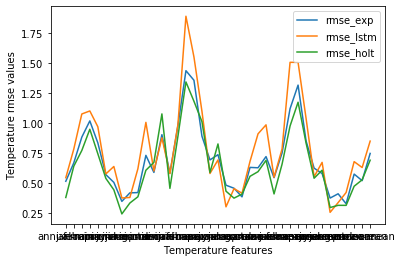

In [124]:
plt.plot(data_rmseT["axis_label"], data_rmseT["x"], label="rmse_exp")
plt.plot(data_rmseT["axis_label"], data_rmseT["y"],label="rmse_lstm")
plt.plot(data_rmseT["axis_label"], data_rmseT["z"], label="rmse_holt")
plt.legend(loc='best')
plt.xlabel('Temperature features')
plt.ylabel('Temperature rmse values')
plt.show()

In [125]:
data_rmseR

{'x': [60.917211442572395,
  85.53031188283303,
  76.23888311275189,
  51.541648493899096],
 'y': [79.36029654436976,
  85.80499312229334,
  86.44229931640642,
  43.79056104271744],
 'z': [60.71868894321681,
  84.35476455298,
  114.66232484466823,
  50.14400719963588],
 'axis_label': ['jun-rain', 'jul-rain', 'aug-rain', 'sept-rain']}

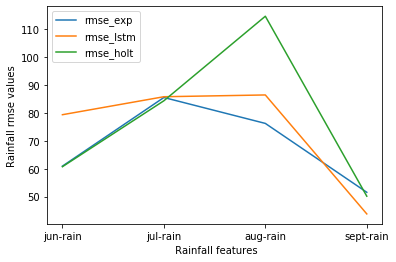

In [126]:
plt.plot(data_rmseR["axis_label"], data_rmseR["x"], label="rmse_exp")
plt.plot(data_rmseR["axis_label"], data_rmseR["y"],label="rmse_lstm")
plt.plot(data_rmseR["axis_label"], data_rmseR["z"], label="rmse_holt")
plt.legend(loc='best')
plt.xlabel(' Rainfall features')
plt.ylabel('Rainfall rmse values')
plt.show()

It can be seen that temperature rmse are nearly similar for all the three methods with two spikes in case of lstm network. The incease in rmse value for LSTM network at these two points can be attributed to overfitting. There were two variables in the training dataset with different kind of time series relationship. Temperature had more degree of linearity as opposed to rainfall which was evident from rmse values of simple exponential method and holt linear trend method. Hence, to accomodate for high non-linearity of rainfall features, complex LSTM networks were used which lead to slight overfitting for temperature features. 
From rainfall rmse plot, it can be clearyly seen that LSMT network has outperformed the other two methods by a huge margin. Holt linear trend method performs worse than even benchmark model. This signifies that there is high degree of non-linearity involved in rainfall features data

## Next task is to find rainfall dependency on monthly temperatures using deep learning model

In [127]:
#creating dataset for supervised learning
data_sl = data_df.copy()

In [128]:
# creating a new column for annual rainfall as sum of the four month rainfall
data_sl['AnnualRain'] = data_sl['jun-rain'].values + data_sl['jul-rain'].values + data_sl['aug-rain'].values + data_sl['sept-rain'].values

In [129]:
# creating list of Y in Y = aX + b
Y = ['jun-rain', 'jul-rain','aug-rain', 'sept-rain', 'AnnualRain']

In [130]:
data_sl.head()

,year,annual-min,jan-min,feb-min,mar-min,apr-min,may-min,jun-min,jul-min,aug-min,...,aug-mean,sep-mean,oct-mean,nov-mean,dec-mean,jun-rain,jul-rain,aug-rain,sept-rain,AnnualRain
0,1901,19.51,13.58,14.72,17.91,20.93,23.18,24.05,23.82,23.58,...,26.98,26.26,25.08,21.73,18.95,99.3,295.4,354.8,113.8,863.3
1,1902,19.44,13.08,14.20,18.44,21.30,23.63,23.97,23.68,23.34,...,27.05,25.95,24.37,21.33,18.78,62.3,334.2,237.6,216.0,850.1
2,1903,19.25,13.20,14.55,17.12,20.67,22.95,23.85,23.53,23.29,...,26.63,26.34,24.57,20.96,18.29,96.2,392.7,286.6,211.5,987.0
3,1904,19.22,13.04,14.07,17.70,21.42,23.02,23.64,23.35,23.03,...,26.73,25.84,24.36,21.07,18.84,180.5,259.1,200.9,165.8,806.3
4,1905,19.03,12.83,12.74,16.88,19.62,23.32,24.13,23.93,24.31,...,27.47,26.29,26.16,22.07,18.71,59.8,340.6,178.9,204.1,783.4


In [131]:
# creating X in Y = aX + b
X = data_sl.drop(data_sl.columns[[0,40,41,42,43,44]], axis=1)

In [132]:
X.shape

(116, 39)

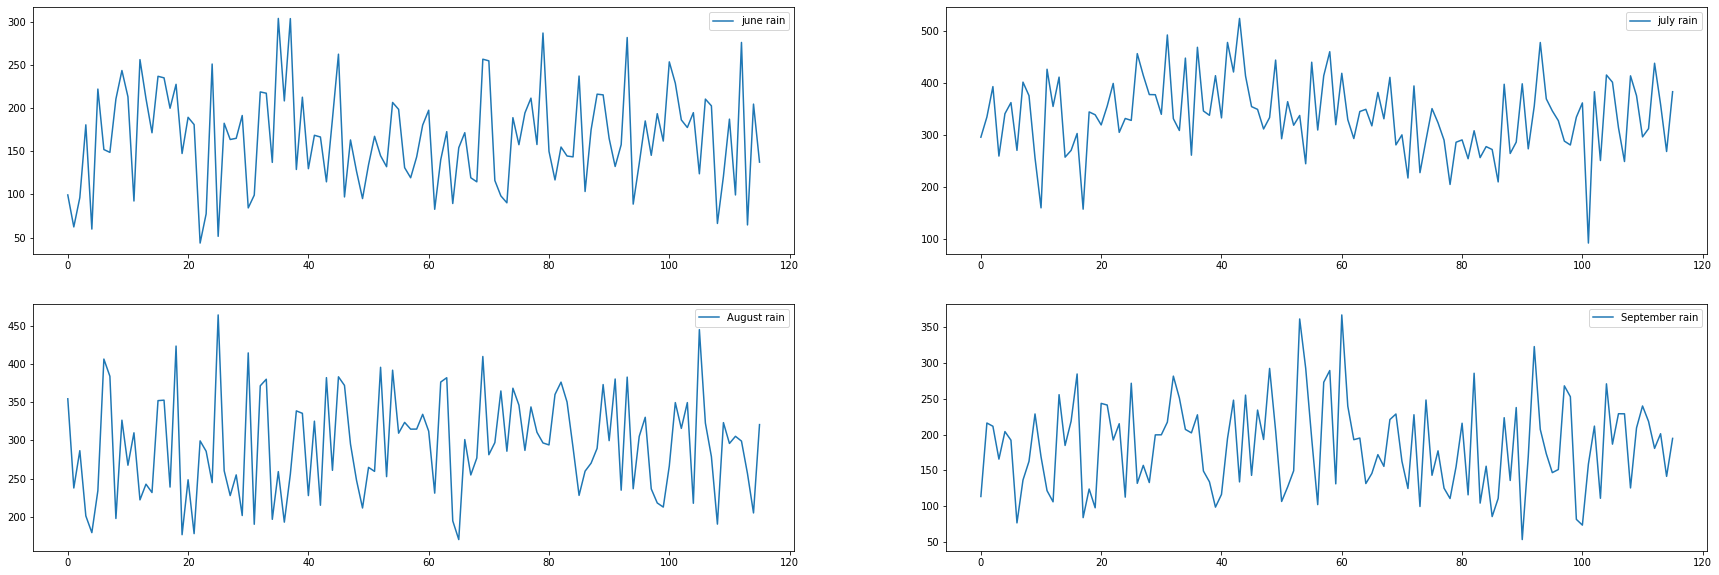

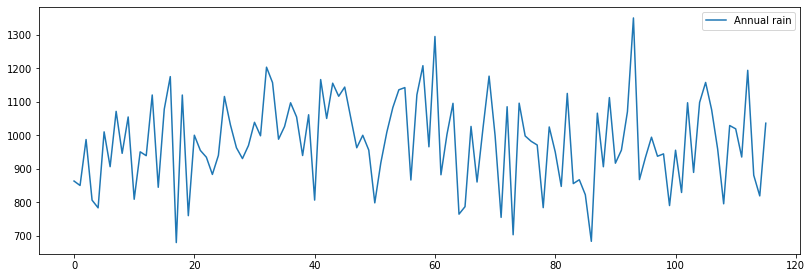

In [133]:
Y = ['jun-rain', 'jul-rain','aug-rain', 'sept-rain', 'AnnualRain']
#Visualizing rainfall data only
f1 = plt.figure(figsize=(30,10))
f2 = plt.figure(figsize=(30,10))
#subplot (4 rows, 2 columns, first plot)
ax1 = f1.add_subplot(2, 2, 1)
ax1.plot(data_sl.index.values, data_sl['jun-rain'], label='june rain') 
ax1.legend(loc='best')


#subplot (4 rows, 2 columns, second plot)
ax2 = f1.add_subplot(2, 2, 2)
ax2.plot(data_sl.index.values, data_sl['jul-rain'], label='july rain')
ax2.legend(loc='best')

#subplot (4 rows, 2 columns, third plot)
ax3 = f1.add_subplot(2, 2, 3)
ax3.plot(data_sl.index.values, data_sl['aug-rain'], label='August rain')
ax3.legend(loc='best')

#subplot (4 rows, 2 columns, fourth plot)
ax4 = f1.add_subplot(2, 2, 4)
ax4.plot(data_sl.index.values, data_sl['sept-rain'], label='September rain')
ax4.legend(loc='best')

#subplot (4 rows, 2 columns, fifth plot)
ax5 = f2.add_subplot(2, 2, 1)
ax5.plot(data_sl.index.values, data_sl['AnnualRain'], label='Annual rain')
ax5.legend(loc='best')

In [134]:
X.shape[1]

39

In [135]:
Z = X.copy()

In [136]:
#defining model
n_in, n_h1, n_h2, n_out = X.shape[1], 128, 128, 1
model = nn.Sequential(nn.Linear(n_in,n_h1),
                     nn.LeakyReLU(0.1),
                     nn.Linear(n_h1,n_h2),
                     nn.LeakyReLU(0.1),
                     nn.Linear(n_h2,n_out))

In [137]:
# defining criterion
criterion = nn.MSELoss()
# defining optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)

In [138]:
X = Z.copy()
#converting X dataframe into tensor values
X = torch.tensor(X.values)
#Scaling X in range [-1, 1]
scaler_temp = preprocessing.MinMaxScaler(feature_range=(-1, 1))
X = scaler_temp.fit_transform(X)
#splitting X into train test data
ratio = 0.15
X_train, X_test = train_test_split(X, test_size=ratio) #output is a numpy array
#converting numpy array into tensor
X_train, X_test = torch.from_numpy(X_train), torch.from_numpy(X_test)
RMSE_train = {}
training_loss = {}
validation_loss = {}
Y_hat = {}
for item in Y:
    #converting item in Y into tensor values
    y = torch.tensor(data_sl[item].values)
    #converting y_hat from 1D tensor to 2D tensor
    y = y.reshape(-1, 1)
    #scaling y in range [-1,1]
    y = scaler_temp.fit_transform(y)
    #spitting y into train test data
    y_train, y_test = train_test_split(y, test_size=ratio)
    #converting numpy array into tensor
    y_train, y_test = torch.from_numpy(y_train), torch.from_numpy(y_test)
    
    use_cuda = torch.cuda.is_available()
    model.train()
    test_loss_min = np.Inf
    n_epoch = 500
    for epoch in range(1, n_epoch+1):
        train_loss = 0.0
        test_loss = 0.0
        if use_cuda:
            X_train, y_train = X_train.cuda(), y_train.cuda()
            
        #forward pass
        y_pred = model(X_train.float())
        
        #initializing gradiet to zero
        optimizer.zero_grad()
        # determining loss
        loss_train = criterion(y_pred, y_train.float())
        #performing backpropagation
        loss_train.backward()
        #updating weights
        optimizer.step()
        
        #updating train_loss
        train_loss += loss_train.data - train_loss
        
        #validating the model
        model.eval()
        if use_cuda:
            X_test, y_test = X_test.cuda(), y_test.cuda()
        
        y_test_pred = model(X_test.float())
        loss_test = criterion(y_test_pred, y_test.float())
        
        test_loss += loss_test.data - test_loss
        
        #printing loss every 50 epoch
        if epoch%50 == 0:
            print("Epoch: {} \tTraining loss: {:.6f} \t Test loss: {:.6f}".format(epoch, train_loss, test_loss))
            
        #saving model if there is decrement in test loss
        if test_loss < test_loss_min:
            print("Saving model: Test loss decreased from {:.6f} to {:.6f}".format(test_loss_min, test_loss))
            torch.save(model.state_dict(), 'SavedModel/model_%s.pt'%(item))
            test_loss_min = test_loss
    #saving final training and validation loss for each parameter
    training_loss[item] = train_loss
    validation_loss[item] = test_loss
    # calculating rmse for final prediction
    y_test_pred = y_test_pred.detach().numpy()
    rmse = sqrt(mean_squared_error(y_test, y_test_pred))
    y_test_pred = scaler_temp.inverse_transform(y_test_pred)
    Y_hat[item] = y_test_pred
    RMSE_train[item] = rmse
    

Saving model: Test loss decreased from inf to 0.221314
Epoch: 50 	Training loss: 0.202788 	 Test loss: 0.221359
Epoch: 100 	Training loss: 0.202003 	 Test loss: 0.221423
Epoch: 150 	Training loss: 0.201254 	 Test loss: 0.221503
Epoch: 200 	Training loss: 0.200538 	 Test loss: 0.221599
Epoch: 250 	Training loss: 0.199855 	 Test loss: 0.221708
Epoch: 300 	Training loss: 0.199203 	 Test loss: 0.221831
Epoch: 350 	Training loss: 0.198580 	 Test loss: 0.221965
Epoch: 400 	Training loss: 0.197986 	 Test loss: 0.222109
Epoch: 450 	Training loss: 0.197418 	 Test loss: 0.222263
Epoch: 500 	Training loss: 0.196874 	 Test loss: 0.222427
Saving model: Test loss decreased from inf to 0.193666
Saving model: Test loss decreased from 0.193666 to 0.193640
Saving model: Test loss decreased from 0.193640 to 0.193613
Saving model: Test loss decreased from 0.193613 to 0.193587
Saving model: Test loss decreased from 0.193587 to 0.193561
Saving model: Test loss decreased from 0.193561 to 0.193535
Saving mode

Saving model: Test loss decreased from 0.190584 to 0.190560
Saving model: Test loss decreased from 0.190560 to 0.190536
Saving model: Test loss decreased from 0.190536 to 0.190512
Saving model: Test loss decreased from 0.190512 to 0.190488
Saving model: Test loss decreased from 0.190488 to 0.190464
Saving model: Test loss decreased from 0.190464 to 0.190441
Saving model: Test loss decreased from 0.190441 to 0.190417
Saving model: Test loss decreased from 0.190417 to 0.190393
Saving model: Test loss decreased from 0.190393 to 0.190369
Saving model: Test loss decreased from 0.190369 to 0.190345
Saving model: Test loss decreased from 0.190345 to 0.190321
Saving model: Test loss decreased from 0.190321 to 0.190297
Saving model: Test loss decreased from 0.190297 to 0.190274
Saving model: Test loss decreased from 0.190274 to 0.190250
Saving model: Test loss decreased from 0.190250 to 0.190226
Saving model: Test loss decreased from 0.190226 to 0.190202
Saving model: Test loss decreased from 0

Saving model: Test loss decreased from 0.187528 to 0.187506
Saving model: Test loss decreased from 0.187506 to 0.187485
Saving model: Test loss decreased from 0.187485 to 0.187463
Saving model: Test loss decreased from 0.187463 to 0.187441
Saving model: Test loss decreased from 0.187441 to 0.187419
Saving model: Test loss decreased from 0.187419 to 0.187397
Saving model: Test loss decreased from 0.187397 to 0.187375
Saving model: Test loss decreased from 0.187375 to 0.187353
Saving model: Test loss decreased from 0.187353 to 0.187331
Saving model: Test loss decreased from 0.187331 to 0.187310
Saving model: Test loss decreased from 0.187310 to 0.187288
Saving model: Test loss decreased from 0.187288 to 0.187266
Saving model: Test loss decreased from 0.187266 to 0.187244
Saving model: Test loss decreased from 0.187244 to 0.187223
Saving model: Test loss decreased from 0.187223 to 0.187201
Saving model: Test loss decreased from 0.187201 to 0.187179
Saving model: Test loss decreased from 0

Saving model: Test loss decreased from 0.184712 to 0.184691
Saving model: Test loss decreased from 0.184691 to 0.184671
Saving model: Test loss decreased from 0.184671 to 0.184651
Saving model: Test loss decreased from 0.184651 to 0.184631
Saving model: Test loss decreased from 0.184631 to 0.184611
Saving model: Test loss decreased from 0.184611 to 0.184591
Saving model: Test loss decreased from 0.184591 to 0.184571
Saving model: Test loss decreased from 0.184571 to 0.184551
Epoch: 400 	Training loss: 0.115420 	 Test loss: 0.184531
Saving model: Test loss decreased from 0.184551 to 0.184531
Saving model: Test loss decreased from 0.184531 to 0.184511
Saving model: Test loss decreased from 0.184511 to 0.184491
Saving model: Test loss decreased from 0.184491 to 0.184471
Saving model: Test loss decreased from 0.184471 to 0.184451
Saving model: Test loss decreased from 0.184451 to 0.184431
Saving model: Test loss decreased from 0.184431 to 0.184412
Saving model: Test loss decreased from 0.1

Saving model: Test loss decreased from 0.345564 to 0.345510
Saving model: Test loss decreased from 0.345510 to 0.345457
Saving model: Test loss decreased from 0.345457 to 0.345403
Saving model: Test loss decreased from 0.345403 to 0.345350
Saving model: Test loss decreased from 0.345350 to 0.345297
Saving model: Test loss decreased from 0.345297 to 0.345244
Saving model: Test loss decreased from 0.345244 to 0.345190
Saving model: Test loss decreased from 0.345190 to 0.345137
Saving model: Test loss decreased from 0.345137 to 0.345084
Saving model: Test loss decreased from 0.345084 to 0.345031
Saving model: Test loss decreased from 0.345031 to 0.344978
Saving model: Test loss decreased from 0.344978 to 0.344925
Saving model: Test loss decreased from 0.344925 to 0.344872
Saving model: Test loss decreased from 0.344872 to 0.344819
Saving model: Test loss decreased from 0.344819 to 0.344766
Saving model: Test loss decreased from 0.344766 to 0.344714
Saving model: Test loss decreased from 0

Saving model: Test loss decreased from 0.338806 to 0.338758
Saving model: Test loss decreased from 0.338758 to 0.338710
Saving model: Test loss decreased from 0.338710 to 0.338662
Saving model: Test loss decreased from 0.338662 to 0.338614
Saving model: Test loss decreased from 0.338614 to 0.338565
Saving model: Test loss decreased from 0.338565 to 0.338517
Saving model: Test loss decreased from 0.338517 to 0.338469
Saving model: Test loss decreased from 0.338469 to 0.338421
Saving model: Test loss decreased from 0.338421 to 0.338373
Saving model: Test loss decreased from 0.338373 to 0.338326
Saving model: Test loss decreased from 0.338326 to 0.338278
Saving model: Test loss decreased from 0.338278 to 0.338230
Saving model: Test loss decreased from 0.338230 to 0.338182
Saving model: Test loss decreased from 0.338182 to 0.338134
Saving model: Test loss decreased from 0.338134 to 0.338086
Saving model: Test loss decreased from 0.338086 to 0.338039
Saving model: Test loss decreased from 0

Saving model: Test loss decreased from 0.332656 to 0.332613
Saving model: Test loss decreased from 0.332613 to 0.332569
Saving model: Test loss decreased from 0.332569 to 0.332525
Saving model: Test loss decreased from 0.332525 to 0.332482
Saving model: Test loss decreased from 0.332482 to 0.332439
Saving model: Test loss decreased from 0.332439 to 0.332395
Saving model: Test loss decreased from 0.332395 to 0.332352
Saving model: Test loss decreased from 0.332352 to 0.332308
Epoch: 300 	Training loss: 0.218556 	 Test loss: 0.332265
Saving model: Test loss decreased from 0.332308 to 0.332265
Saving model: Test loss decreased from 0.332265 to 0.332222
Saving model: Test loss decreased from 0.332222 to 0.332178
Saving model: Test loss decreased from 0.332178 to 0.332135
Saving model: Test loss decreased from 0.332135 to 0.332092
Saving model: Test loss decreased from 0.332092 to 0.332049
Saving model: Test loss decreased from 0.332049 to 0.332006
Saving model: Test loss decreased from 0.3

Saving model: Test loss decreased from 0.327139 to 0.327100
Saving model: Test loss decreased from 0.327100 to 0.327061
Saving model: Test loss decreased from 0.327061 to 0.327021
Saving model: Test loss decreased from 0.327021 to 0.326982
Saving model: Test loss decreased from 0.326982 to 0.326943
Saving model: Test loss decreased from 0.326943 to 0.326903
Saving model: Test loss decreased from 0.326903 to 0.326864
Saving model: Test loss decreased from 0.326864 to 0.326825
Saving model: Test loss decreased from 0.326825 to 0.326786
Saving model: Test loss decreased from 0.326786 to 0.326747
Saving model: Test loss decreased from 0.326747 to 0.326707
Saving model: Test loss decreased from 0.326707 to 0.326668
Saving model: Test loss decreased from 0.326668 to 0.326629
Saving model: Test loss decreased from 0.326629 to 0.326590
Saving model: Test loss decreased from 0.326590 to 0.326551
Saving model: Test loss decreased from 0.326551 to 0.326512
Saving model: Test loss decreased from 0

Saving model: Test loss decreased from 0.224734 to 0.224698
Saving model: Test loss decreased from 0.224698 to 0.224663
Saving model: Test loss decreased from 0.224663 to 0.224628
Saving model: Test loss decreased from 0.224628 to 0.224593
Saving model: Test loss decreased from 0.224593 to 0.224558
Saving model: Test loss decreased from 0.224558 to 0.224524
Saving model: Test loss decreased from 0.224524 to 0.224489
Saving model: Test loss decreased from 0.224489 to 0.224454
Saving model: Test loss decreased from 0.224454 to 0.224419
Saving model: Test loss decreased from 0.224419 to 0.224384
Saving model: Test loss decreased from 0.224384 to 0.224350
Saving model: Test loss decreased from 0.224350 to 0.224315
Saving model: Test loss decreased from 0.224315 to 0.224280
Saving model: Test loss decreased from 0.224280 to 0.224246
Saving model: Test loss decreased from 0.224246 to 0.224211
Saving model: Test loss decreased from 0.224211 to 0.224176
Saving model: Test loss decreased from 0

Saving model: Test loss decreased from 0.220287 to 0.220255
Saving model: Test loss decreased from 0.220255 to 0.220224
Saving model: Test loss decreased from 0.220224 to 0.220193
Saving model: Test loss decreased from 0.220193 to 0.220161
Saving model: Test loss decreased from 0.220161 to 0.220130
Saving model: Test loss decreased from 0.220130 to 0.220099
Saving model: Test loss decreased from 0.220099 to 0.220067
Saving model: Test loss decreased from 0.220067 to 0.220036
Epoch: 200 	Training loss: 0.177745 	 Test loss: 0.220005
Saving model: Test loss decreased from 0.220036 to 0.220005
Saving model: Test loss decreased from 0.220005 to 0.219974
Saving model: Test loss decreased from 0.219974 to 0.219943
Saving model: Test loss decreased from 0.219943 to 0.219912
Saving model: Test loss decreased from 0.219912 to 0.219881
Saving model: Test loss decreased from 0.219881 to 0.219849
Saving model: Test loss decreased from 0.219849 to 0.219818
Saving model: Test loss decreased from 0.2

Saving model: Test loss decreased from 0.216325 to 0.216297
Saving model: Test loss decreased from 0.216297 to 0.216268
Saving model: Test loss decreased from 0.216268 to 0.216240
Saving model: Test loss decreased from 0.216240 to 0.216212
Saving model: Test loss decreased from 0.216212 to 0.216184
Saving model: Test loss decreased from 0.216184 to 0.216156
Saving model: Test loss decreased from 0.216156 to 0.216128
Saving model: Test loss decreased from 0.216128 to 0.216100
Saving model: Test loss decreased from 0.216100 to 0.216072
Saving model: Test loss decreased from 0.216072 to 0.216044
Saving model: Test loss decreased from 0.216044 to 0.216016
Saving model: Test loss decreased from 0.216016 to 0.215988
Saving model: Test loss decreased from 0.215988 to 0.215960
Saving model: Test loss decreased from 0.215960 to 0.215932
Saving model: Test loss decreased from 0.215932 to 0.215904
Saving model: Test loss decreased from 0.215904 to 0.215876
Saving model: Test loss decreased from 0

Saving model: Test loss decreased from 0.212762 to 0.212736
Saving model: Test loss decreased from 0.212736 to 0.212711
Saving model: Test loss decreased from 0.212711 to 0.212685
Saving model: Test loss decreased from 0.212685 to 0.212660
Saving model: Test loss decreased from 0.212660 to 0.212635
Saving model: Test loss decreased from 0.212635 to 0.212610
Saving model: Test loss decreased from 0.212610 to 0.212584
Saving model: Test loss decreased from 0.212584 to 0.212559
Saving model: Test loss decreased from 0.212559 to 0.212534
Saving model: Test loss decreased from 0.212534 to 0.212509
Saving model: Test loss decreased from 0.212509 to 0.212483
Saving model: Test loss decreased from 0.212483 to 0.212458
Saving model: Test loss decreased from 0.212458 to 0.212433
Saving model: Test loss decreased from 0.212433 to 0.212408
Saving model: Test loss decreased from 0.212408 to 0.212383
Saving model: Test loss decreased from 0.212383 to 0.212358
Saving model: Test loss decreased from 0

Saving model: Test loss decreased from 0.142521 to 0.142515
Saving model: Test loss decreased from 0.142515 to 0.142510
Saving model: Test loss decreased from 0.142510 to 0.142504
Saving model: Test loss decreased from 0.142504 to 0.142498
Saving model: Test loss decreased from 0.142498 to 0.142492
Saving model: Test loss decreased from 0.142492 to 0.142486
Saving model: Test loss decreased from 0.142486 to 0.142480
Saving model: Test loss decreased from 0.142480 to 0.142475
Epoch: 100 	Training loss: 0.158023 	 Test loss: 0.142469
Saving model: Test loss decreased from 0.142475 to 0.142469
Saving model: Test loss decreased from 0.142469 to 0.142463
Saving model: Test loss decreased from 0.142463 to 0.142457
Saving model: Test loss decreased from 0.142457 to 0.142451
Saving model: Test loss decreased from 0.142451 to 0.142446
Saving model: Test loss decreased from 0.142446 to 0.142440
Saving model: Test loss decreased from 0.142440 to 0.142434
Saving model: Test loss decreased from 0.1

Saving model: Test loss decreased from 0.141785 to 0.141780
Saving model: Test loss decreased from 0.141780 to 0.141775
Saving model: Test loss decreased from 0.141775 to 0.141770
Saving model: Test loss decreased from 0.141770 to 0.141764
Saving model: Test loss decreased from 0.141764 to 0.141759
Saving model: Test loss decreased from 0.141759 to 0.141754
Saving model: Test loss decreased from 0.141754 to 0.141749
Saving model: Test loss decreased from 0.141749 to 0.141744
Saving model: Test loss decreased from 0.141744 to 0.141738
Saving model: Test loss decreased from 0.141738 to 0.141733
Saving model: Test loss decreased from 0.141733 to 0.141728
Saving model: Test loss decreased from 0.141728 to 0.141723
Saving model: Test loss decreased from 0.141723 to 0.141718
Saving model: Test loss decreased from 0.141718 to 0.141712
Saving model: Test loss decreased from 0.141712 to 0.141707
Saving model: Test loss decreased from 0.141707 to 0.141702
Saving model: Test loss decreased from 0

Saving model: Test loss decreased from 0.141127 to 0.141123
Saving model: Test loss decreased from 0.141123 to 0.141118
Saving model: Test loss decreased from 0.141118 to 0.141113
Saving model: Test loss decreased from 0.141113 to 0.141109
Saving model: Test loss decreased from 0.141109 to 0.141104
Saving model: Test loss decreased from 0.141104 to 0.141099
Saving model: Test loss decreased from 0.141099 to 0.141095
Saving model: Test loss decreased from 0.141095 to 0.141090
Saving model: Test loss decreased from 0.141090 to 0.141085
Saving model: Test loss decreased from 0.141085 to 0.141081
Saving model: Test loss decreased from 0.141081 to 0.141076
Saving model: Test loss decreased from 0.141076 to 0.141072
Saving model: Test loss decreased from 0.141072 to 0.141067
Saving model: Test loss decreased from 0.141067 to 0.141062
Saving model: Test loss decreased from 0.141062 to 0.141058
Saving model: Test loss decreased from 0.141058 to 0.141053
Saving model: Test loss decreased from 0

Saving model: Test loss decreased from 0.140536 to 0.140531
Saving model: Test loss decreased from 0.140531 to 0.140527
Saving model: Test loss decreased from 0.140527 to 0.140523
Saving model: Test loss decreased from 0.140523 to 0.140519
Saving model: Test loss decreased from 0.140519 to 0.140515
Saving model: Test loss decreased from 0.140515 to 0.140511
Saving model: Test loss decreased from 0.140511 to 0.140506
Saving model: Test loss decreased from 0.140506 to 0.140502
Epoch: 500 	Training loss: 0.156678 	 Test loss: 0.140498
Saving model: Test loss decreased from 0.140502 to 0.140498


In [139]:
RMSE_train

{'jun-rain': 0.4716214913982261,
 'jul-rain': 0.4273124324782735,
 'aug-rain': 0.5694086062591183,
 'sept-rain': 0.46009646556158246,
 'AnnualRain': 0.3748307758853707}

In [140]:
#extracting only temperature values from lSTM prediction. This is X in Y = aX + b
temp_pred = np.delete(actual_test_predictions, np.s_[39:44], axis=1)
# extracting only rainfall values from LSTM prediction
rain_pred = np.delete(actual_test_predictions, np.s_[0:39], axis=1)
# Y in Y = aX + b
test_rain = np.delete(test_data_lstm, np.s_[0:39], axis=1)
temp_pred.shape, rain_pred.shape, test_rain.shape

((10, 39), (10, 5), (10, 5))

In [141]:
test_rain[:, 0]

array([210.3, 202.5,  66.3, 120.9, 187.1,  99.3, 275.9,  64.6, 204.5,
       137.3], dtype=float32)

In [142]:
#Scaling temp_pred in range [-1, 1]
temp_pred = scaler_temp.fit_transform(temp_pred)
#converting to tensor
temp_pred = torch.from_numpy(temp_pred)
temp_pred.shape

torch.Size([10, 39])

In [143]:
temp_pred[:, 0]

tensor([ 1.0000,  0.2381, -0.1601, -0.7033, -1.0000, -0.8284, -0.4679, -0.1994,
         0.0534,  0.2366], dtype=torch.float64)

In [144]:
#creating min max scaler for the particular rainfall features
scaler_rain = preprocessing.MinMaxScaler(feature_range=(-1,1))
y_rain = scaler_rain.fit_transform(test_rain)

In [145]:
y_rain.T[0]

array([ 0.37908196,  0.30525327, -0.98390913, -0.46710837,  0.15948904,
       -0.671557  ,  1.0000001 , -1.        ,  0.3241837 , -0.3118788 ],
      dtype=float32)

In [146]:
Y

['jun-rain', 'jul-rain', 'aug-rain', 'sept-rain', 'AnnualRain']

In [147]:
Y_hat = np.zeros(shape=(5,10))
RMSE_test = {}
for i, item in enumerate(Y):
    #loading model corresponding to item
    model.load_state_dict(torch.load('SavedModel/model_%s.pt'%(item)))
    # Testing the model
    model.eval()
    y_hat = model(temp_pred.float())
    y_hat = y_hat.detach().numpy().reshape(-1)
    rmse = sqrt(mean_squared_error(y_rain.transpose()[i], y_hat))
    RMSE_test[item] = rmse
    Y_hat[i] = y_hat


In [148]:
Y_hat

array([[ 0.05561257,  0.06700474,  0.16814567,  0.15680245,  0.06717592,
         0.05583363,  0.08307683,  0.10430624,  0.14500616,  0.15067793],
       [ 0.04929274,  0.06332721,  0.1604261 ,  0.14733616,  0.05621248,
         0.04130565,  0.06732577,  0.08918545,  0.13102832,  0.13903092],
       [ 0.01720052,  0.0232299 ,  0.11833817,  0.10498618,  0.01575081,
         0.00345172,  0.03131292,  0.05422845,  0.09689315,  0.10458029],
       [-0.00733188, -0.00967233,  0.08262233,  0.06702216, -0.02129948,
        -0.02875823,  0.0028593 ,  0.02713392,  0.07032121,  0.07656126],
       [-0.01815118, -0.02365497,  0.06850228,  0.05236915, -0.03585272,
        -0.04133215, -0.00862654,  0.01592781,  0.05906801,  0.06514484]])

In [149]:
y_hat_transformed = scaler_rain.inverse_transform(Y_hat.transpose())

In [150]:
y_hat_transformed

array([[ 176.12546366,  347.75816299,  257.94728241,  182.28208051,
         990.83887132],
       [ 177.32904623,  349.08442067,  258.34944232,  182.1486747 ,
         989.7438933 ],
       [ 188.01458517,  358.26026577,  264.69316345,  187.40947052,
        1008.07857784],
       [ 186.81617341,  357.02326641,  263.80258613,  186.52026057,
        1004.86889239],
       [ 177.34713109,  348.4120793 ,  257.85058727,  181.48592728,
         987.31715021],
       [ 176.14881851,  347.00338372,  257.03023758,  181.06077831,
         986.22701855],
       [ 179.02706294,  349.46228486,  258.88857969,  182.86297733,
         992.73379916],
       [ 181.26994908,  351.52802427,  260.41704529,  184.24663067,
         997.61888671],
       [ 185.5698964 ,  355.48217635,  263.26278111,  186.70830642,
        1006.20163095],
       [ 186.16911881,  356.23842152,  263.77551309,  187.06398912,
        1007.41061509]])

In [151]:
RMSE_test

{'jun-rain': 0.6871544446363296,
 'jul-rain': 0.6242980352855675,
 'aug-rain': 0.7629930840525035,
 'sept-rain': 0.6974090941471524,
 'AnnualRain': 0.6102076002094644}

### * One can see that RMSE_test(predicted via DNN LSTM) is much less than rmse_lstm (predicted by LSTM) 